## Setup

In [76]:
from IPython import get_ipython
ipython = get_ipython()
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")

import os;

# os.environ["ACCELERATE_DISABLE_RICH"] = "1"

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import sys
from functools import partial
import json
from typing import List, Tuple, Union, Optional, Callable, Dict
import torch as t
from torch import Tensor
from sklearn.linear_model import LinearRegression
import numpy as np
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import einops
from tqdm import tqdm
from jaxtyping import Float, Int, Bool
from pathlib import Path
import pandas as pd
import circuitsvis as cv
import webbrowser
from IPython.display import display
from transformer_lens import utils, ActivationCache, HookedTransformer, HookedTransformerConfig
from transformer_lens.hook_points import HookPoint
from transformer_lens.components import LayerNorm
from eindex import eindex

# t.set_grad_enabled(False)

# Make sure exercises are in the path
chapter = r"chapter1_transformers"
exercises_dir = Path(f"{os.getcwd().split(chapter)[0]}/{chapter}/exercises").resolve()
section_dir = exercises_dir / "monthly_algorithmic_problems" / "october23_sorted_list"
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

from monthly_algorithmic_problems.october23_sorted_list.model import create_model
from monthly_algorithmic_problems.october23_sorted_list.training import train, TrainArgs
from monthly_algorithmic_problems.october23_sorted_list.dataset import SortedListDataset
from plotly_utils import hist, bar, imshow

device = t.device("cpu")

MAIN = __name__ == "__main__"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

In [77]:
dataset = SortedListDataset(size=10, list_len=5, max_value=15, seed=43)
print("Sequence = ", dataset[0])
print("Str toks = ", dataset.str_toks[0])

Sequence =  tensor([ 7,  5, 11,  4,  1, 16,  1,  4,  5,  7, 11])
Str toks =  ['7', '5', '11', '4', '1', 'SEP', '1', '4', '5', '7', '11']


## Transformer

In [78]:
# 1-layer transformer, 3 heads, no MLP

args = TrainArgs(
    list_len=10,
    max_value=50,
    trainset_size=150_000,
    valset_size=10_000,
    epochs=25,
    batch_size=512,
    lr_start=1e-3,
    lr_end=1e-4,
    weight_decay=0.005,
    seed=42,
    d_model=96,
    d_head=48,
    n_layers=1,
    n_heads=2,
    d_mlp=None,
    normalization_type="LN",
    use_wandb=False,
    device=device,
)
# model = train(args)

In [79]:
# Save the model
filename = section_dir / "AF_sorted_list_model.pt"
# t.save(model.state_dict(), filename)

# Check we can load in the model
model = create_model(
    list_len=10,
    max_value=50,
    seed=0,
    d_model=96,
    d_head=48,
    n_layers=1,
    n_heads=2,
    normalization_type="LN",
    d_mlp=None
)
model.load_state_dict(t.load(filename))

<All keys matched successfully>

In [80]:
dataset = SortedListDataset(size=500, list_len=10, max_value=50, seed=43)

logits, cache = model.run_with_cache(dataset.toks)
logits: Tensor = logits[:, dataset.list_len:-1, :]

targets = dataset.toks[:, dataset.list_len+1:]

logprobs = logits.log_softmax(-1) # [batch seq_len vocab_out]
probs = logprobs.softmax(-1)

batch_size, seq_len = dataset.toks.shape
logprobs_correct = eindex(logprobs, targets, "batch seq [batch seq]")
probs_correct = eindex(probs, targets, "batch seq [batch seq]")

avg_cross_entropy_loss = -logprobs_correct.mean().item()

print(f"Average cross entropy loss: {avg_cross_entropy_loss:.3f}")
print(f"Mean probability on correct label: {probs_correct.mean():.3f}")
print(f"Median probability on correct label: {probs_correct.median():.3f}")
print(f"Min probability on correct label: {probs_correct.min():.3f}")


Average cross entropy loss: 0.039
Mean probability on correct label: 0.966
Median probability on correct label: 0.981
Min probability on correct label: 0.001


## Code to visualize the final token predictions

In [81]:

seq = lambda x,l : [i for i in range(x+l-1,x-1,-1)]  + [ 51 ] + [ i for i in range(x,x+l) ]

def show(ds,probs):

    list_len = int( (ds.size(-1)-1 ) / 2 ) 
    seq_len  = ds.size(-1)
    strs = [ str(i.item()) for i in ds[:list_len] ] 
    x    = [ ds[j] for j in range( list_len+1, seq_len) ]
    indices = t.argmax(probs.T,dim=0)

    print(indices)

    chf = lambda s,t,i : "〇" if (s==t and t==i) else "●" if (s==i) else " "
    text = [[ chf( str(str_tok),str(target.item()),str(indices[t].item())) for t,target in enumerate(ds[list_len+1:seq_len])]
            for str_tok in dataset.vocab]
    imshow(
        probs.T,
        y=dataset.vocab,
        # x=x,
        labels={"x": "Token", "y": "Vocab"},
        xaxis_tickangle=0,
        title=f"Sample model probabilities:<br>Unsorted = ({','.join( strs ) })",
        text=text,
        range_color=[0, .5, 1],
        color_continuous_scale=["white", "purple", "blue"],
        width=800,
        height=800,
    )



## Analyzed case - Sort all values 0 to 50

- Create a sequence of tokens [50,49,...,0 , 51 , 0,.....49,50] which is 103 tokens long
- Hack the position embeddings. Besides the position of the SEP, they shouldn't matter 
- Compute a 1-layer transformer to examine these sequences of 103 tokens (instead of 21 that the model was trained on) to see how the model is working. 


In [82]:
t.set_printoptions(precision=2,sci_mode=False)

# generate a sequence of tokens [50,49,...,0,51,0,.....49,50]
total_tokens   = 51
model_list_len = 10
start_pos = total_tokens-model_list_len
tokens    = t.tensor([seq(0,total_tokens)]) #51
list_len  = int( (tokens.size(-1)-1 ) / 2 ) 
print("tokens",tokens.shape)
print("tokens",tokens)

# calculate the normalized embedding
# use a hack on the position embedding to extend to the right shape
# the hack shouldn't matter much
resid_pre    = model.embed.W_E[tokens]
pos_embed     = t.zeros_like(resid_pre)
pos_embed_model = model.pos_embed(tokens)
finish_pos = start_pos + pos_embed_mod.size(1)
pos_embed[:,start_pos : finish_pos, : ] = pos_embed_model
if (start_pos>0) : #0,-1
    pos_embed[:, 0 : start_pos, : ] = pos_embed_mod[:,0,:].unsqueeze(1).expand(-1,start_pos,-1)
    pos_embed[:, finish_pos:  , : ] = pos_embed_mod[:,-1,:].unsqueeze(1).expand(-1,start_pos,-1)
resid_pre = resid_pre + pos_embed
normalized = model.blocks[0].ln1(resid_pre) 


# calculate the attention scores
q = einops.einsum(
            normalized, model.W_Q[0],
            "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head",
        ) + model.b_Q[0]

k = einops.einsum(
    normalized, model.W_K[0],
    "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head",
) + model.b_K[0]

v = einops.einsum(
    normalized, model.W_V[0],
    "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head",
) + model.b_V[0]

attn_scores = einops.einsum(
    q, k,
    "batch posn_Q nheads d_head, batch posn_K nheads d_head -> batch nheads posn_Q posn_K",
)

def apply_causal_mask(
    attn_scores: Float[Tensor, "batch n_heads query_pos key_pos"]
) -> Float[Tensor, "batch n_heads query_pos key_pos"]:
    '''
    Applies a causal mask to attention scores, and returns masked scores.
    '''
    all_ones = t.ones(attn_scores.size(-2), attn_scores.size(-1), device=attn_scores.device)
    mask = t.triu(all_ones, diagonal=1).bool()
    attn_scores.masked_fill_(mask, model.IGNORE)
    return attn_scores

model.register_buffer("IGNORE", t.tensor(-1e5, dtype=t.float32, device=device))


attn_scores_masked = apply_causal_mask(attn_scores / model.cfg.d_head ** 0.5)
attn_pattern = attn_scores_masked.softmax(-1)

z = einops.einsum(
    v, attn_pattern,
    "batch posn_K nheads d_head, batch nheads posn_Q posn_K -> batch posn_Q nheads d_head",
)

# Calculate output (by applying matrix W_O and summing over heads, then adding bias b_O)
attn_out = einops.einsum(
    z, model.W_O[0],
    "batch posn_Q nheads d_head, nheads d_head d_model -> batch posn_Q d_model",
) + model.b_O[0]

# caculate the final residual stream, final)embedding, the logits and the token probabilities. 
resid_post = attn_out + resid_pre

final_embedding = model.ln_final(resid_post)
logits = model.unembed(final_embedding)
logits = logits[:, list_len:-1, :]
logprobs = logits.log_softmax(-1) # [batch seq_len vocab_out]
token_probs = logprobs.softmax(-1)

show(tokens[0],token_probs[0])

tokens torch.Size([1, 103])
tokens tensor([[50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33,
         32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15,
         14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0, 51,  0,  1,
          2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
         20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
         38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]])
tensor([ 0,  1,  3,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 33, 34, 35, 36, 36, 34, 35,
        36, 37, 38, 39, 40,  0, 42, 43, 44, 46,  5,  6,  0,  0,  0])


### Despite not being trained to sort sequences this long, the model does a good job
- <b> it misses at postion 2, 29-33 and 45-50 </b>
- the misses from 45-50 are most interesting because it predicts values close to 0. Could be that there is some periodicity at work here which is mapping these values close to 0. 

## Analyze the initial normalized embeddings 
- look at the principle components of the embeddings for the tokens 0-51

In [83]:

import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pandas as pd

# use the normzlized embedding calculated above
embedding = normalized
st = int( (embedding.shape[1] -1) / 2 )
reshaped_embedding = embedding[:,st:,:].squeeze(0)

U, S, V = t.svd(reshaped_embedding)

projection = reshaped_embedding @ V[:, :20]
pdf = pd.DataFrame(projection.detach().cpu().numpy(), columns=[ 'PC'+str(i+1) for i in range(20)])

# Create a scatter plot of the projection onto the first two principal components
token_labels = [i for i in range(0, pdf.shape[0] )]

fig = px.scatter(x=pdf['PC1'], y=pdf['PC2'], text=token_labels)
fig.update_layout(
    title='Projections of Original Embeddings onto 2 Principal Components',
    xaxis_title='PC1',
    yaxis_title='PC2',
    width=600,
    height=600,
)
fig.show()

# Show the amount explained by principle components
variance_explained = S ** 2 / (S ** 2).sum()

# Convert to percentage
variance_explained_percentage = variance_explained * 100

# Create a bar chart to show variance explained
fig = go.Figure(
    data=[
        go.Bar(
            x=[f'PC{i+1}' for i in range(len(variance_explained))],
            y=variance_explained_percentage.tolist(),
        )
    ],
    layout=go.Layout(
        title='Variance Explained by Principal Components',
        xaxis_title='Principal Component',
        yaxis_title='Variance Explained (%)',
    )
)

fig.show()


### Periodicity found. The embeddings predict the order of the value of the token. 
- The embeddings projected on to PC1 & PC2 are arranged in a (rough) circle. 
- It takes many principle components to explain the data. Chances are the embeddings encode relative variations between the tokens (e.g. predict previous embedding from next embedding or vice versa)
### Show that the embeddings predict the value of the token
1. A regression predicting token value from the embedding should have a high R^2
2. A regresssion predicing the next embedding from the previous embedding should have a high R^2

R-squared: 0.99


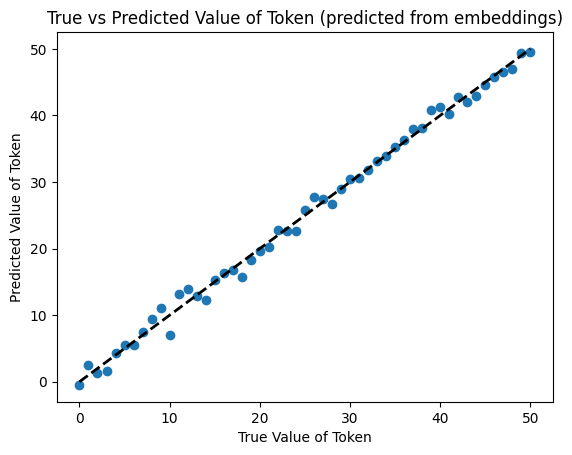

In [84]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# use the normalized initial embeddings calculated above
st = int((normalized.shape[1] - 1)/2 + 1)
embeddings = normalized[:,st:,:].squeeze(0).detach().cpu().numpy()


seq_len = embeddings.shape[0]
d_model = embeddings.shape[1]

X = embeddings  # features are the values of the positional encodings
y = np.arange(seq_len).reshape(-1, 1)  # target is the position of each encoding

# Fit linear regression
lr = LinearRegression()
lr.fit(X, y)

# Predict positions
predicted_positions = lr.predict(X)

# Print out R-squared value
print(f'R-squared: {lr.score(X, y):.2f}')

# Visualize true vs predicted positions
plt.scatter(y, predicted_positions)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('True Value of Token')
plt.ylabel('Predicted Value of Token')
plt.title('True vs Predicted Value of Token (predicted from embeddings)')
plt.show()

### 1. The value of a token can be predicted by the token embedding (r^2=99%)

### 2. Can the previous embedding  be predicted by the next embedding ? 

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import torch.nn.functional as F

# Prepare data for regression
X = embeddings[:-1]  # encodings at position p-1
y = embeddings[1:]   # encodings at position p

# Fit linear regression
lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)

y_tensor = t.tensor(y, dtype=t.float32)
y_pred_tensor = t.tensor(y_pred, dtype=t.float32)

y_l2_normalized      = F.normalize(y_tensor, p=2, dim=0)
y_pred_l2_normalized = F.normalize(y_pred_tensor, p=2, dim=0)

gram_matrix = t.mm( y_l2_normalized, y_pred_l2_normalized.t())

colorscale = [[0, 'blue'], [.5, 'white'], [1.0, 'green']]

fig = go.Figure(data=go.Contour(
    z=gram_matrix.detach().cpu().numpy(),
    colorscale=colorscale,
    zmin=-1,
    zmax=1,
    x=list(range(1, gram_matrix.size(-1))),  
    y=list(range(1, gram_matrix.size(-1))),
))

fig.update_layout(
    title='Gram Matrix Predicted vs Actual (correlation)',
    xaxis_title='Actual Embedding position p-1',
    yaxis_title='Predicted Embedding at position p-1',
    yaxis_autorange='reversed', 
    autosize=False,
    height=500,
    width=500,
)
print("predicted embedding correlates highest with actual embedding")
fig.show()

predicted embedding correlates highest with actual embedding


### 2. Yes, given an embedding for value X, a linear transformation exists to change that embedding to value X-1

- (e.g. A 'next' value in the sort sequence can be found from a previous value in the sort sequence ) 

### This means that the query, key and value matrix are probably optimized to find the best transformation that attends (or finds) the next value in the sort sequence

- Let's compare the attention pattern matrix to the grammed normalized embedding matrix with a causal mask and softmax applied. The attention pattern and the grammed embedding matrix should look similar as they would be doing essentially the same thing, except the grammed matrix is not optimized to attend to values far away in value from the original embedding.

### Calculate the gram matrix of embeddings vs previous embedding, and then compare to attention patterns. 

In [86]:
import plotly.subplots as sp
import plotly.graph_objects as go


embedding = normalized

st = int( (embedding.shape[1] -1) / 2 + 1)

reshaped_embedding = embedding[:,:,:].squeeze(0)
reshaped_embeddings_p = reshaped_embedding[2:]
reshaped_embeddings_p_minus_1 = reshaped_embedding[:-2]

gram_matrix = torch.mm(reshaped_embeddings_p, reshaped_embeddings_p_minus_1.t())
gram_matrix2 = gram_matrix.unsqueeze(0).unsqueeze(0)
gram_matrix_masked = apply_causal_mask( gram_matrix2 / model.cfg.d_head ** 0.5)
gram_pattern = gram_matrix_masked.softmax(-1)

def visualize(attention_matrix,title=None) :

    xlim = int( (attention_matrix.shape[2]-1)/2)
    ylim = attention_matrix.shape[3]

    i = 0
    for calc_idx in range( attention_matrix.shape[0] ):
        for head_idx in range( attention_matrix.shape[1]):
            am = attention_matrix[calc_idx, head_idx,:,:]
            am = t.flip(am, [0])
            fig = go.Figure(data=go.Contour(
                z = t.log(am).detach().cpu().numpy(),
                colorscale='Viridis',
                colorbar=dict(len=0.2, y=(calc_idx + 0.5) / 5),
                textfont={"size":8},
                showscale=True,
                contours=dict(
                    start=-12,
                    end=0,
                    size=1,
                ),
            ))

            if title is not None :
                title_text = title
            else :
                title_text = f'Atteninon Pattern (logged) Layer {calc_idx}, Head {head_idx}'     

            fig.update_layout(
                height=500,
                width=500,
                title_text= title_text,
                showlegend=True,
                # yaxis_autorange='reversed', 
            )
            fig.show() #UNCOMMENT TO SHOW EACH HEATMAP

visualize( gram_pattern, title="Normalized Embeddings - log(Gram Matrix)")
visualize( attn_pattern)


### Conclusion: And there you have it. The model works by organizing the initial normalized embeddings so that relative values can be attended to via a transformation.
- This is very similar to how the positional embeddings work in the 'Attention is all you need' paper. 


## Advesarial cases. 

- Recall the misses for values 29-33 and 45-50 
- Let's construct some cases that are likely to fail. 
- These cases are designed to include values which are similar to the advesarial target as in the original analyzed case (except the 45-50 targets, which are including the wrap around values 0-9). Remember the original embeddings are organized in a circle. So 50 might just come before 0. 


In [87]:
#Cases likely to fail
ds_pos29_33 = [ seq(x,10) for x in range(29,34,1) ]
ds_pos45_50 = [ seq(0,10) for i in range(45,51,1) ]
def sub(ds,x) :
    ds[0]  = 45 + x
    ds[-1] = 45 + x
    return ds
ds_pos45_50 = [ sub(ds,x) for x,ds in enumerate(ds_pos45_50) ]

#Use model to predict results
ds = t.tensor(ds_pos29_33 + ds_pos45_50)
list_len = int( (ds.size(-1)-1 ) / 2 ) 
logits, cache = model.run_with_cache(ds)
logits: Tensor = logits[:, list_len:-1, :]
targets = ds[:, list_len+1:]
logprobs = logits.log_softmax(-1) # [batch seq_len vocab_out]
probs = logprobs.softmax(-1)

#Show results
for i in range(ds.size(0)):
    show(ds[i],probs[i])

tensor([25, 30, 31, 32, 33, 34, 35, 36, 37, 38])


tensor([25, 31, 32, 33, 34, 35, 36, 37, 38, 39])


tensor([35, 32, 33, 34, 35, 36, 37, 38, 39, 40])


tensor([36, 33, 34, 35, 36, 37, 38, 39, 40, 41])


tensor([36, 34, 35, 36, 37, 38, 39, 40, 41, 42])


tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 8])


tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 8])


tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 8])


tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 8])


tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 8])


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 50])


### Target 50 is a success! all the rest of the cases show model failures.  

#### I think the model could be improved by initializing the token embeddings using sins and cosines (e.g. pos embeddings in Attention is all you need) while ensuring that the max value does not have a representation that is close to the 0 value. 